In [1]:
%pip install --upgrade pip
%pip install davos
import davos

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
smuggle pandas as pd # pip: pandas==1.5.1
smuggle numpy as np # pip: numpy==1.23.4
smuggle seaborn as sns # pip: seaborn==0.12.1
smuggle dill as pickle # pip: dill==0.3.6

smuggle h5py # pip: h5py==3.7.0
smuggle pathos # pip: pathos==0.3.0
smuggle quail # pip: quail==0.2.1
smuggle requests # pip: requests==2.28.1
smuggle os
smuggle warnings

from tqdm smuggle tqdm # pip: tqdm==4.64.1
from matplotlib smuggle pyplot as plt #pip: matplotlib==3.6.2
from matplotlib.ticker smuggle MaxNLocator
from pathos.multiprocessing smuggle ProcessingPool as Pool # pip: pathos==0.3.0
from multiprocessing smuggle cpu_count  # pip: multiprocess==0.70.14

# local functions
from dataloader import datadir, grouping, feature_groupings, colors, descriptions, sort_by_grouping
from analyze import analyze_data

# Download/organize the data and do some basic analyses

Compute for each experiment:
- Probability of first recall (pfr): plot probability of recalling each item *first* as a function of the presentation position
    - Advanced: also do probability of $n^{th}$ recall for $n \in \{0, ..., 15\}$
- Lag conditional response probability (lagcrp): plot the probability of recalling each item next in the sequence, as a function of their positions relative to the position of the item recalled just previously
- Serial position curve (spc): plot the probability of recalling each item (at *any* point) as a function of the presentation position
- Fingerprint: compute clustering scores across different features

For each analysis:
- Look at "early" vs. "late" lists

For fingerprints, compute on a per-list basis and aggregate into early vs. late lists

In [3]:
results_file = 'analyzed_500_iter.pkl'
results, analyses, listgroups = analyze_data(savefile=results_file)

In [4]:
# hack for recovering fingerprint features (feature tags are lost in the pickling process)
order_file = os.path.join(datadir, 'scratch', 'feature_order.pkl')
if os.path.exists(order_file):
    with open(order_file, 'rb') as f:
        orders = pickle.load(f)
else:
    data = fetch_data()
    fingerprints = {x: d.analyze('fingerprint') for x, d in data.items()}
    orders = {k: x.data.columns.tolist() for k, x in fingerprints.items()}

    with open(order_file, 'wb') as f:
        pickle.dump(orders, f)

for k, f in results['fingerprint'].items():
    f.data.columns = orders[k]

Re-organize fingerprints by list group-- we'll use the group-averaged fingerprints in most analyses, but later on we'll use the per-list versions.

In [5]:
def organize_by_listgroup(x, groups):
    if type(x) is dict:
        return {k: organize_by_listgroup(v, groups[k]) for k, v in x.items()}
    
    subjs = x.data.index.levels[0].values
    lists = x.data.index.levels[1].values

    if all([type(g) is list for g in groups]):
        listgroups = {s: g for s, g in enumerate(groups)}
    else:
        listgroups = {s: groups for s in np.unique(subjs)}
    
    data = x.data.reset_index()
    data['listgroup'] = data.apply(lambda r: listgroups[int(r['Subject'])][int(r['List'])], axis=1)
    data = data.groupby(['listgroup', 'Subject']).mean().reset_index()
    data = data.drop('List', axis=1).rename({'listgroup': 'List'}, axis=1).set_index(['Subject', 'List'])

    return quail.FriedEgg(data=data, analysis=x.analysis, list_length=x.list_length, n_lists=x.n_lists, n_subjects=x.n_subjects,
                          position=x.position)

fingerprints_by_list = results['fingerprint']  # per-list fingerprints
results['fingerprint'] = organize_by_listgroup(results['fingerprint'], listgroups)  # averaged within each listgroup

Set up figure directory...

In [6]:
figdir = os.path.join(os.path.split(os.getcwd())[0], 'paper', 'figures', 'source')
if not os.path.exists(figdir):
    os.makedirs(figdir)

# Figure 1: recall dynamics across different experimental conditions

We'll use four basic analyses to characterize recall dynamics:
  - What word do participants recall *first*?  (Probability of first recall)
  - How to participants *transition* from recalling one word to recalling other words (from the same list)?  (Lag Conditional Response Probability, Fingerprints)
  - Which words do participants recall *overall*? (Serial position curve)

In [7]:
non_adaptive = [x for x in descriptions.values() if x != 'adaptive']

def select_conds(results, conds='all'):
    return {k: v for k, v in results.items() if conds == 'all' or k in conds}

def select_lists(fried, lists='all'):
    if type(fried) is dict:
        return {k: select_lists(v, lists=lists) for k, v in fried.items()}

    x_data = fried.data.copy()
    if lists == 'all':
        x_data.index = pd.MultiIndex.from_tuples([(i, 'Average') for i, _ in x.data.index], names=x.data.index.names)        
    elif type(lists) is str:
        x_data = x_data.query(f'List == "{lists}"')
    else:
        x_data = x_data.query(f'List in @lists')

    return quail.FriedEgg(data=x_data.copy(), analysis=fried.analysis, list_length=fried.list_length,
                          n_lists=fried.n_lists, n_subjects=fried.n_subjects, position=fried.position)


def filter(x, include_conds='all', include_lists='all'):
    x = {k: select_lists(v, lists=include_lists) for k, v in select_conds(x, conds=include_conds).items()}
    include_conds = list(x.keys())
    include_conds.sort()

    include_keys = []
    for k, v in x.items():
        include_keys.extend(np.unique([i for _, i in v.data.index]).tolist())
    include_keys = np.unique(include_keys).tolist()

    return x, include_conds, include_keys


def combo_lineplot(x, include_conds='all', include_lists='all', fname=None, xlabel=None, ylabel=None, xlim=None, ylim=None, palette=None):
    x, include_conds, include_lists = filter(x, include_conds, include_lists)

    fig = plt.figure(figsize=(3, 2.5))
    ax = plt.gca()
    
    for c in include_conds:
        if palette is None:
            if c.lower() in colors:
                next_palette = [colors[c.lower()]]
            else:
                next_palette = [colors[i.lower()] for i in include_lists]
        else:
            next_palette = palette
    
        x[c].plot(ax=ax, palette=next_palette, legend=False)
    
    if xlabel is not None:
        plt.xlabel(xlabel)
    
    if ylabel is not None:
        plt.ylabel(ylabel)

    if xlim is not None:
        plt.xlim(xlim)
    
    if ylim is not None:
        plt.ylim(ylim)
    
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')
    
    return fig

Probability of first recall (early + late)

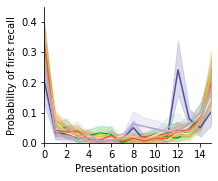

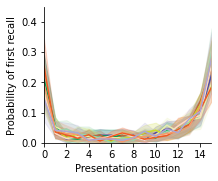

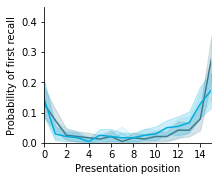

In [8]:
combo_lineplot(results['pnr'][0], include_conds=non_adaptive, include_lists='Early', fname='pfr_early_nonadaptive', xlabel='Presentation position', ylabel='Probability of first recall', ylim=[0, 0.45]);
combo_lineplot(results['pnr'][0], include_conds=non_adaptive, include_lists='Late', fname='pfr_late_nonadaptive', xlabel='Presentation position', ylabel='Probability of first recall', ylim=[0, 0.45]);
combo_lineplot(results['pnr'][0], include_conds='adaptive', include_lists=['destabilize', 'random', 'stabilize'], fname='pfr_adaptive', xlabel='Presentation position', ylabel='Probability of first recall', ylim=[0, 0.45]);

Lag conditional response probability

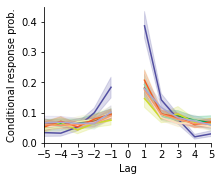

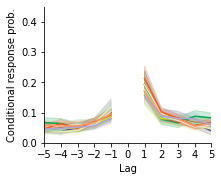

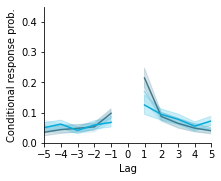

In [9]:
combo_lineplot(results['lagcrp'], include_conds=non_adaptive, include_lists='Early', fname='crp_early_nonadaptive', xlabel='Lag', ylabel='Conditional response prob.', ylim=[0, 0.45]);
combo_lineplot(results['lagcrp'], include_conds=non_adaptive, include_lists='Late', fname='crp_late_nonadaptive', xlabel='Lag', ylabel='Conditional response prob.', ylim=[0, 0.45]);
combo_lineplot(results['lagcrp'], include_conds='adaptive', include_lists=['destabilize', 'random', 'stabilize'], fname='crp_adaptive', xlabel='Lag', ylabel='Conditional response prob.', ylim=[0, 0.45]);

Serial position curves

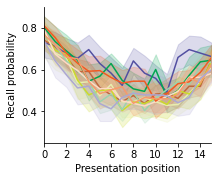

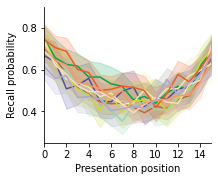

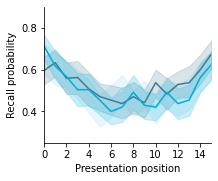

In [10]:
combo_lineplot(results['spc'], include_conds=non_adaptive, include_lists='Early', fname='spc_early_nonadaptive', xlabel='Presentation position', ylabel='Recall probability', ylim=[0.25, 0.9]);
combo_lineplot(results['spc'], include_conds=non_adaptive, include_lists='Late', fname='spc_late_nonadaptive', xlabel='Presentation position', ylabel='Recall probability', ylim=[0.25, 0.9]);
combo_lineplot(results['spc'], include_conds='adaptive', include_lists=['destabilize', 'random', 'stabilize'], fname='spc_adaptive', xlabel='Presentation position', ylabel='Recall probability', ylim=[0.25, 0.9]);

Fingerprints

In [11]:
def reorder_df(df, column, order):
    new_dfs = []
    for val in order:
        new_dfs.append(df.query(f'{column} == "{val}"'))
    
    return pd.concat(new_dfs, axis=0)


def rename_features(x):
    rename = {'pos': 'location', 'first_letter': 'first letter', 'firstLetter': 'first letter', 'wordLength': 'length'}
    df = x.data.rename(rename, axis=1)
    return df[sort_by_grouping(df.columns.values.tolist(), feature_groupings)]


def combo_fingerprint_plot(x, include_conds='all', include_lists='all', fname=None, ylim=None, palette=None, xlabel='Dimension', ylabel='Clustering score', figsize=(15, 2.5)):
    def melt_by_list(x, cond='-'):
        x = rename_features(x).reset_index()
        x = x.rename({c: c.capitalize() for c in x.columns}, axis=1)
        x['Condition'] = cond
        x = x.rename({'List': 'Condition', 'Condition': 'List'}, axis=1)

        return x.melt(id_vars=['Subject', 'List', 'Condition'], var_name='Dimension', value_name='Clustering score')

    def melt_fingerprint(x, cond='-'):
        rename = {'pos': 'location', 'first_letter': 'first letter', 'firstLetter': 'first letter', 'wordLength': 'length'}
        x = x.data.rename(rename, axis=1).reset_index()
        x = x.rename({c: c.capitalize() for c in x.columns}, axis=1)
        x['Condition'] = cond

        return x.melt(id_vars=['Subject', 'List', 'Condition'], var_name='Dimension', value_name='Clustering score')

    x, include_conds, include_lists = filter(x, include_conds, include_lists)

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    force_order = ['feature rich', 'reduced (early)', 'reduced (late)', 'reduced',
                   'category', 'size', 'length', 'first letter', 'color', 'location',
                   'adaptive', 'random', 'stabilize', 'destabilize']        

    palette = []
    fingerprints = []
    order = []
    

    for c in [x for x in force_order if x in include_conds]:
        if c == 'adaptive':
            fingerprints.append(melt_by_list(x[c], cond=c))
            palette.extend([colors[x] for x in force_order if x in include_lists])
            order.extend([x for x in force_order if x in include_lists])
        else:
            fingerprints.append(melt_fingerprint(x[c], cond=c))
            palette.append(colors[c])
            order.append(c)
    
    sns.violinplot(data=reorder_df(pd.concat(fingerprints, axis=0), 'Condition', order),
                   x='Dimension', y='Clustering score',
                   hue='Condition',
                   order=['Category', 'Size', 'Length', 'First letter', 'Color', 'Location'],
                   palette=palette, linewidth=1, inner='quartile', scale='width')
    
    if ylim is not None:
        plt.ylim(ylim)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    ax = plt.gca()
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    plt.legend([], [], frameon=False)

    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')
    return fig

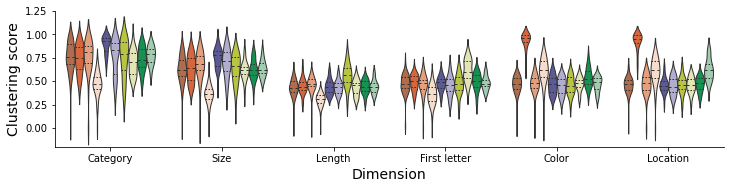

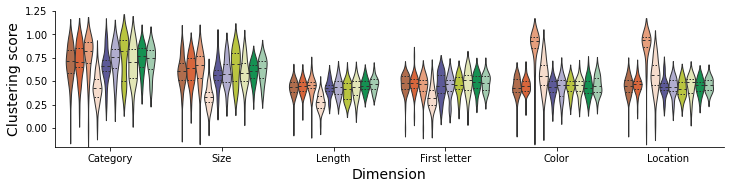

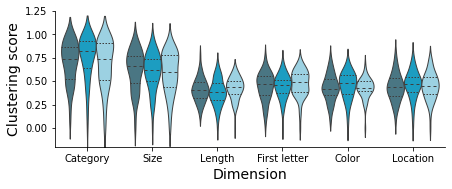

In [53]:
combo_fingerprint_plot(results['fingerprint'], include_conds=non_adaptive, include_lists='Early', fname='fingerprint_early_nonadaptive', ylim=[-0.2, 1.25], figsize=(12, 2.5));
combo_fingerprint_plot(results['fingerprint'], include_conds=non_adaptive, include_lists='Late', fname='fingerprint_late_nonadaptive', ylim=[-0.2, 1.25], figsize=(12, 2.5));
combo_fingerprint_plot(results['fingerprint'], include_conds=['adaptive'], include_lists=['random', 'stabilize', 'destabilize'], fname='fingerprint_adaptive', ylim=[-0.2, 1.25], figsize=(7, 2.5));



# Figure 2: early versus late differences in recall dynamics

For the non-adaptive conditions, recall dynamics on early vs. late lists reflect performance under difference conditions:
  - Feature rich, reduced: control conditions
    - Feature rich: random word order on both early and late lists; visual features vary across words
    - Reduced: random word order on both early and late lists; visual features held constant across words
  - Category, size, length, first letter, color, location
    - Words are sorted by the given feature during the first 8 lists ("Early")
    - Words order is randomized for the second 8 lists ("Late")
  - Reduced (early), Reduced (late):
    - Word order is randomized in all lists, for both conditions
    - Reduced (early): visual features are held constant for the first 8 lists ("Early") but vary for the second 8 lists ("Late")
    - Reduced (late): visual features vary for the first 8 lists but are held constant for the second 8 lists
  
Each adaptive conditions reflects lists presented in a different (relative) order, according to the participant's average "fingerprint" from all lists up to that point:
  - Random: control condition; words are sorted randomly
  - Stabilize: words are sorted to *maximize* agreement with the participant's average fingerprint
  - Destabilize: words are sorted to *minimize* agreement with the participant's average fingerprint

In [13]:
def egg_diff(a, b):
    if type(a) is dict:
        results = {}
        for k in a.keys():
            results[k] = egg_diff(a[k], b[k])
        return results
    
    for i in ['analysis', 'list_length', 'n_lists', 'n_subjects', 'position']:
        assert getattr(a, i) == getattr(b, i), ValueError('Incompatable eggs; cannot take difference')
    assert np.all([i == j for i, j in zip(a.data.shape, b.data.shape)]), ValueError('Incompatable eggs; cannot take difference')
    
    #idx = pd.MultiIndex.from_tuples([(i, 'Difference') for i, _ in a.data.index], names=a.data.index.names)
    diffs = pd.DataFrame(index=a.data.index, data=a.data.values - b.data.values, columns=a.data.columns)  # Hack: name "differences" using the reference item's name so that coloring works correctly

    return quail.FriedEgg(data=diffs, analysis=a.analysis, list_length=a.list_length,
                          n_lists=a.n_lists, n_subjects=a.n_subjects, position=a.position)
    
def get_diffs(x, contrast={'Late': 'Early'}, include_conds='all' ):
    include_lists = []
    for k, v in contrast.items():
        include_lists.extend([k, v])
    include_lists = np.unique(include_lists).tolist()
        
    x, include_conds, include_lists = filter(x, include_conds, include_lists)
    
    diffs = {}
    for k, v in contrast.items():
        diffs[f'{k} - {v}'] = egg_diff(select_lists(x, k), select_lists(x, v))

    return diffs

def stack_diffs(diffs, include_conds='all'):
    if include_conds == 'all':
        include_conds = []
        for k1, v1 in diffs.items():
            for k2, _ in v1.items():
                include_conds.append(k2)
        include_conds = np.unique(include_conds).tolist()
    elif type(include_conds) is str:
        include_conds = [include_conds]    

    template = diffs
    while type(template) is not quail.FriedEgg:
        template = template[list(template.keys())[0]]
    
    analysis = template.analysis
    list_length = template.list_length
    n_lists = template.n_lists
    n_subjects = template.n_subjects
    position = template.position

    results = {}
    for c in include_conds:
        results[c] = quail.FriedEgg(pd.concat([x[c].data for x in diffs.values()], axis=0),
            analysis=analysis, list_length=list_length, n_lists=n_lists,
            n_subjects=n_subjects, position=position)
    return results

Probability of first recall differences

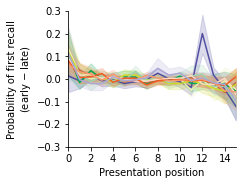

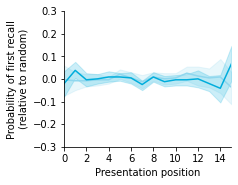

In [14]:
pfr_diffs = get_diffs(results['pnr'][0], contrast={'Early': 'Late'}, include_conds=non_adaptive)['Early - Late']
combo_lineplot(pfr_diffs, include_conds=non_adaptive, include_lists=['Early'], fname='pfr_nonadaptive_diffs', xlabel='Presentation position', ylabel='Probability of first recall\n(early $-$ late)', ylim=[-0.3, 0.3]);

pfr_diffs_adaptive = get_diffs(results['pnr'][0], contrast={'stabilize': 'random', 'destabilize': 'random'}, include_conds='adaptive')
combo_lineplot(stack_diffs(pfr_diffs_adaptive), include_lists=['stabilize', 'destabilize'], fname='pfr_adaptive_diffs', xlabel='Presentation position', ylabel='Probability of first recall\n(relative to random)', ylim=[-0.3, 0.3]);

Lag conditional response probability differences

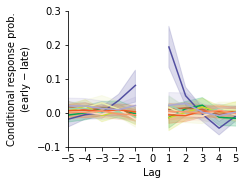

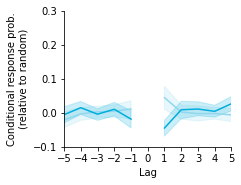

In [15]:
crp_diffs = get_diffs(results['lagcrp'], contrast={'Early': 'Late'}, include_conds=non_adaptive)['Early - Late']
combo_lineplot(crp_diffs, include_conds=non_adaptive, include_lists=['Early'], fname='crp_nonadaptive_diffs', xlabel='Lag', ylabel='Conditional response prob.\n(early $-$ late)', ylim=[-0.1, 0.3]);

crp_diffs_adaptive = get_diffs(results['lagcrp'], contrast={'stabilize': 'random', 'destabilize': 'random'}, include_conds='adaptive')
combo_lineplot(stack_diffs(crp_diffs_adaptive), include_lists=['stabilize', 'destabilize'], fname='crp_adaptive_diffs', xlabel='Lag', ylabel='Conditional response prob.\n(relative to random)', ylim=[-0.1, 0.3]);

Serial position curve differences

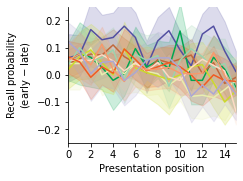

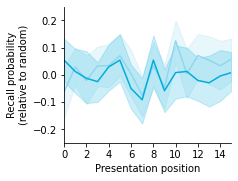

In [16]:
spc_diffs = get_diffs(results['spc'], contrast={'Early': 'Late'}, include_conds=non_adaptive)['Early - Late']
combo_lineplot(spc_diffs, include_conds=non_adaptive, include_lists=['Early'], fname='spc_nonadaptive_diffs', xlabel='Presentation position', ylabel='Recall probability\n(early $-$ late)', ylim=[-0.25, 0.25]);

spc_diffs_adaptive = get_diffs(results['spc'], contrast={'stabilize': 'random', 'destabilize': 'random'}, include_conds='adaptive')
combo_lineplot(stack_diffs(spc_diffs_adaptive), include_lists=['stabilize', 'destabilize'], fname='spc_adaptive_diffs', xlabel='Presentation position', ylabel='Recall probability\n(relative to random)', ylim=[-0.25, 0.25]);

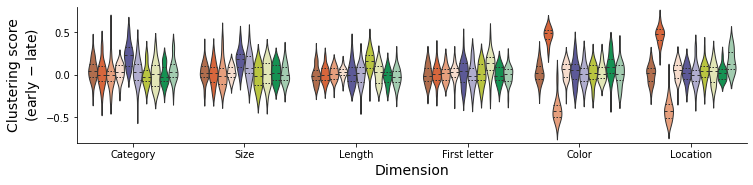

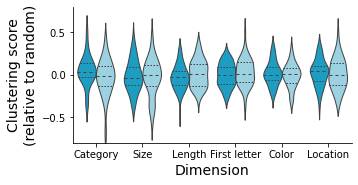

In [56]:
fingerprint_diffs = get_diffs(results['fingerprint'], contrast={'Early': 'Late'}, include_conds=non_adaptive)['Early - Late']
combo_fingerprint_plot(fingerprint_diffs, include_conds=non_adaptive, include_lists=['Early'], fname='fingerprint_nonadaptive_diffs', ylabel='Clustering score\n(early $-$ late)', ylim=[-0.8, 0.8], figsize=(12, 2.5));

fingerprint_diffs_adaptive = get_diffs(results['fingerprint'], contrast={'stabilize': 'random', 'destabilize': 'random'}, include_conds='adaptive')
combo_fingerprint_plot(stack_diffs(fingerprint_diffs_adaptive), include_lists=['stabilize', 'destabilize'], fname='fingerprint_adaptive_diffs', ylabel='Clustering score\n(relative to random)', ylim=[-0.8, 0.8], figsize=(5, 2.5));

 # Figure 3: detailed recall initiation dynamics

- For each non-adaptive condition, create early, late, and diff heatmaps: row = recall position; column = output position; color = p(recall)
- For each adaptive condition, create stabilize, destabilize, random, and diff (stabilize vs. random, destabilize vs. random) heatmaps in the same format

 

In [18]:
def pnr_matrix(pnr_results, include_conds='all', include_lists='all'):
    positions = range(16)

    if type(include_conds) is str:
        include_conds = [include_conds]
    
    if type(include_lists) is str:
        include_lists = [include_lists]

    conds = [c for c in pnr_results[positions[0]].keys() if 'all' in include_conds or c in include_conds]

    matrices = {}
    for c in conds:
        matrices[c] = {}
        
        x = pd.concat([pnr_results[p][c].data.groupby('List').mean() for p in positions], axis=0)
        lists = np.unique(x.index.values).tolist()

        for ls in lists:
            if 'all' in include_lists or ls in include_lists:
                matrices[c][ls] = x.query(f'List == "{ls}"').reset_index().drop('List', axis=1)

    return matrices

def mini_filter(x, include_conds='all', include_lists='all'):
    conds = []
    lists = []

    if type(include_conds) is str and include_conds != 'all':
        include_conds = [include_conds]

    if type(include_lists) is str and include_lists != 'all':
        include_lists = [include_lists]
    


    results = {}
    for k1 in x.keys():
        if not (include_conds == 'all' or k1 in include_conds):
            continue
        
        results[k1] = {}
        conds.append(k1)
        
        for k2, v in x[k1].items():
            if not (include_lists == 'all' or k2 in include_lists):
                continue

            results[k1][k2] = x[k1][k2]
            lists.append(k2)
    
    return results, np.unique(conds).tolist(), np.unique(lists).tolist()

In [19]:
def sort_by_grouping(vals, groupings):
    sorted_vals = []
    for category, exemplars in groupings.items():
        sorted_vals.extend([x for x in exemplars if x in vals])
    
    missing = [v for v in vals if v not in sorted_vals]
    sorted_vals.extend(missing)
    
    return sorted_vals

In [20]:
def plot_heatmaps(results, include_conds='all', include_lists='all', contrasts=None, fname=None, vmin=0, vmax=1.0, dvmin=-1.0, dvmax=1.0, fontsize=12, width=2.5, height=2, xlabel='', ylabel=''):
    def heatmap(m, title, vmn, vmx, ax, showx=False, showy=False, show_title=False, yprepend='', **kwargs):
        sns.heatmap(m, vmin=vmn, vmax=vmx, ax=ax, cbar=False, **kwargs)

        if showx:
            ax.set_xlabel(xlabel, fontsize=fontsize)
        if showy:
            ax.set_ylabel(yprepend + ylabel, fontsize=fontsize)
        if show_title:
            ax.set_title(title, fontsize=fontsize)
        return plt.gca()
    
    if type(include_lists) is list:
        original_lists = include_lists.copy()
    else:
        original_lists = include_lists
    
    results, include_conds, include_lists = mini_filter(results, include_conds=include_conds, include_lists=include_lists)

    # correct condition/list order
    include_conds = sort_by_grouping(include_conds, feature_groupings)
    if type(original_lists) is list:
        include_lists = [x for x in original_lists if x in include_lists]

    if contrasts is None:
        contrasts = {}
    n_rows = len(include_lists) + len(contrasts.keys())
    n_columns = len(include_conds)

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_columns, sharex=True, sharey=True, squeeze=True, figsize=(width * n_columns, height * n_rows))

    for column, cond in enumerate(include_conds):
        if cond not in results.keys():
            continue
        for row, listtype in enumerate(include_lists):
            if listtype not in results[cond].keys():
                continue
            
            try:
                ax = axes[row, column]
            except IndexError:
                ax = axes[max([row, column])]

            heatmap(results[cond][listtype], cond.capitalize(), vmin, vmax, ax, showx=row == n_rows, showy=column == 0, show_title=row == 0, yprepend=listtype.capitalize() + '\n')
        
        for i, c in enumerate(contrasts.items()):
            k, v = c
            if (k not in results[cond].keys()) or (v not in results[cond].keys()):
                continue
            
            r = len(include_lists) + i
            try:
                ax = axes[r, column]
            except IndexError:
                ax = axes[max([r, column])]
            heatmap(results[cond][k] - results[cond][v], '', dvmin, dvmax, ax, showx=(len(include_lists) + i + 1) == n_rows, showy=column == 0, cmap='mako', yprepend=f'{k.capitalize()} $-$ {v.lower()}\n')
    
    plt.tight_layout()

    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')
    return fig

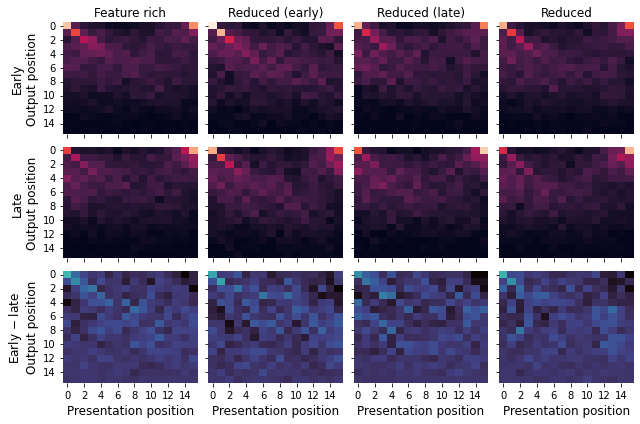

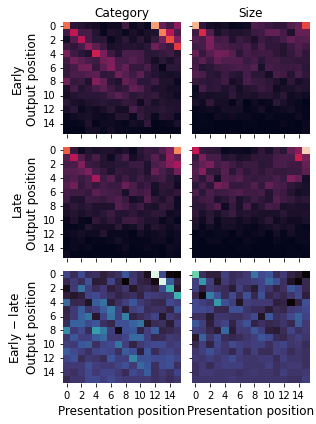

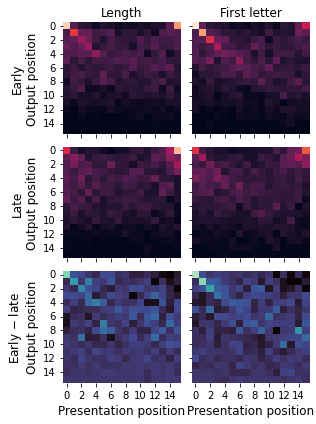

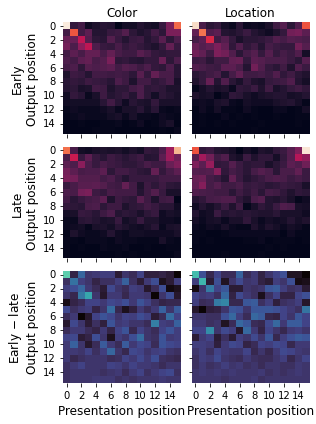

In [21]:
x = pnr_matrix(results['pnr'], include_conds='all')

# non-adaptive heatmaps
for group, conds in feature_groupings.items():
    if group == 'adaptive':
        continue    

    plot_heatmaps(x, include_conds=conds, contrasts={'Early': 'Late'}, fname=f'pnr_heatmaps_{group}', vmin=0, vmax=0.3, dvmin=-0.05, dvmax=0.15, width=2.25, xlabel='Presentation position', ylabel='Output position')
    

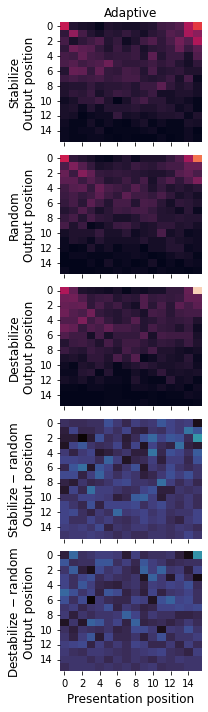

In [22]:
# adaptive heatmaps
plot_heatmaps(x, include_conds=['adaptive'], include_lists=['stabilize', 'random', 'destabilize'], contrasts={'stabilize': 'random', 'destabilize': 'random'}, fname='pnr_heatmaps_adaptive', vmin=0, vmax=0.3, dvmin=-0.05, dvmax=0.15, width=3, height=2, xlabel='Presentation position', ylabel='Output position');

# Figure 4: list order effects (by condition)

For each condition (color), plot recall accuracy (y-axis) as a function of list number (x-axis).
  - Panel 1: random conditions (feature rich, reduced (early), reduced(late), and reduced)
  - Panel 2: feature manipulation conditions
  - Panel 3: adaptive conditions (split by list)

In [23]:
def accuracy2df(accuracy):
    columns = accuracy.keys()
    df = pd.concat([v.data for v in accuracy.values()], axis=1)
    df.columns = columns
    return df.reset_index().melt(id_vars=['Subject', 'List'], var_name='Condition', value_name='Accuracy')

def adaptive_listnum2cond(x):
    return listgroups['adaptive'][int(x['Subject'])][int(x['List'])]

In [24]:
# non-adaptive conditions: organize by results key
random_accuracy = accuracy2df({c: results['accuracy by list'][c] for c in feature_groupings['random']})
nonadaptive_accuracy = accuracy2df({c: results['accuracy by list'][c] for c in non_adaptive if c not in feature_groupings['random']})

# adaptive conditons: assign manually
adaptive_accuracy = results['accuracy by list']['adaptive'].data.reset_index().rename({0: 'Accuracy'}, axis=1)
adaptive_accuracy['Condition'] = adaptive_accuracy.apply(adaptive_listnum2cond, axis=1)

In [25]:
def accuracy_by_list(x, xlim=[0, 15], ylim=[0, 1], fname=None):
    _, inds = np.unique(x['Condition'], return_index=True)
    conds = [x['Condition'][i] for i in sorted(inds)]
    
    palette = [colors[c] for c in conds]
    fig = plt.figure(figsize=(5.5, 2.5))
    sns.lineplot(data=x, x='List', y='Accuracy', hue='Condition', palette=palette, legend=False)
    plt.xlabel('List number', fontsize=12)
    plt.ylabel('Recall probability', fontsize=12)
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')
    return fig

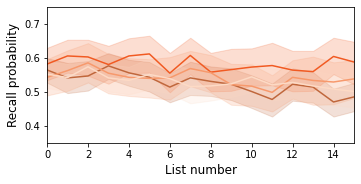

In [26]:
accuracy_by_list(random_accuracy, ylim=[0.35, 0.75], fname='random_accuracy_by_listnum');

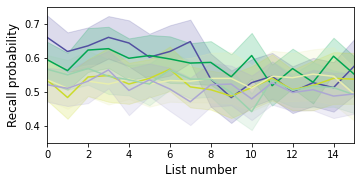

In [27]:
accuracy_by_list(nonadaptive_accuracy, ylim=[0.35, 0.75], fname='nonadaptive_accuracy_by_listnum');

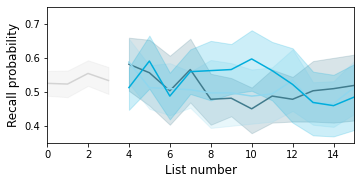

In [28]:
accuracy_by_list(adaptive_accuracy, ylim=[0.35, 0.75], fname='nonadaptive_accuracy_by_listnum');

# Figure 5: Interactions between feature clustering and accuracy

This figure is limited to the non-adaptive and non-random feature rich conditions (i.e., conditions with order manipulations on early vs. late lists).  Note: this will likely need to be split into several figures.

### Panel 1

For each condition, display a single dot for each participant, where the $x$-coordinate shows the early accuracy (averaged across Early lists) and the $y$-coordinate shows the average clustering score (for the given condition's highlighted feature).  The resulting scatterplot shows (a) how different list organizations affect clustering and (b) how different list organizations/clustering affects recall.

In [29]:
def fingerprint_scatterplot_by_category(results, include_conds='all', include_lists='all', x_lists=None, y_lists=None, y='accuracy', average=False, fname=None, xlabel=None, ylabel=None, xlim=None, ylim=None):
    if x_lists is None:
        x_lists = include_lists
    if y_lists is None:
        y_lists = include_lists

    fingerprints, conds, lists = filter(results['fingerprint'], include_conds, x_lists)
    y_data, tmp_conds, tmp_lists = filter(results[y], include_conds, y_lists)

    assert all([c in conds for c in tmp_conds]) and all([c in tmp_conds for c in conds]), 'condition mismatch!'

    x = []

    for c in conds:
        clustering = rename_features(fingerprints[c])[c].reset_index().drop('List', axis=1).set_index('Subject')
        next_y = y_data[c].data.reset_index().drop('List', axis=1).set_index('Subject')

        if average:
            clustering = pd.DataFrame(clustering.mean(axis=0)).T
            next_y = pd.DataFrame(next_y.mean(axis=0)).T
        
        df = pd.concat([clustering, next_y], axis=1).rename({0: y.capitalize(), c: 'Clustering score'}, axis=1)
        df['Condition'] = c
        x.append(df)
    
    combined = pd.concat(x, axis=0)
    
    if average:
        fig = plt.figure(figsize=(1.1 * 3.5, 3.5))
        sns.regplot(data=combined, x=y.capitalize(), y='Clustering score', color='k', marker='.', scatter_kws={'s': 0.1})
        sns.scatterplot(data=combined, x=y.capitalize(), y='Clustering score', hue='Condition', palette=[colors[c] for c in conds], legend=False)
    else:
        sns.lmplot(data=combined, x=y.capitalize(), y='Clustering score', hue='Condition', palette=[colors[c] for c in conds], height=3.5, aspect=1.1)

    ax = plt.gca()
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    if ylim[0] < 0: 
        plt.plot(xlim, [0, 0], 'k--')
    if xlim[0] < 0:
        plt.plot([0, 0], ylim, 'k--')
    
    plt.ylim(ylim)
    plt.xlim(xlim)

    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=14)
    else:
        plt.xlabel(ax.get_xlabel(), fontsize=14)
    
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=14)
    else:
        plt.ylabel(ax.get_ylabel(), fontsize=14)

    fig = plt.gcf()
    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')

    return fig


In [30]:
non_adaptive_exclude_random = ['category', 'size', 'length', 'first letter', 'color', 'location']
accuracy_diffs = get_diffs(results['accuracy'], contrast={'Early': 'Late'}, include_conds=non_adaptive)['Early - Late']

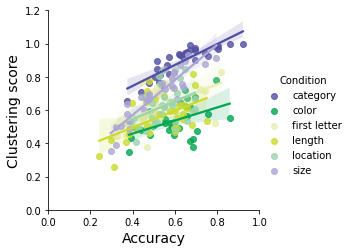

In [31]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, include_lists='Early', y='accuracy', fname='clustering_vs_accuracy_scatterplot_early', xlim=[0, 1], ylim=[0, 1.2]);

### Panel 2

Same as Panel 1, but for late lists.  

This will show whether/how earlier lists' organization affects clustering/performance on later lists.

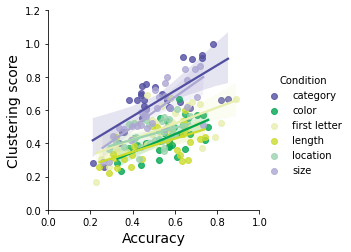

In [32]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, include_lists='Late', y='accuracy', fname='clustering_vs_accuracy_scatterplot_late', xlim=[0, 1], ylim=[0, 1.2]);

### Panel 3

Same as Panels 1 and 2, but the $x$-axis shows accuracy on Late lists and the $y$-axis shows clustering on Early lists.

The resulting scatterplot shows how/whether clustering on early lists carries over to performance on later (random) lists.

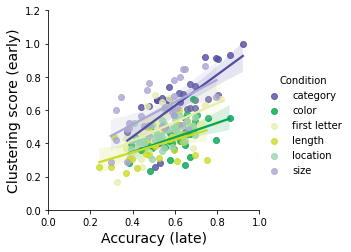

In [33]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, x_lists='Late', y_lists='Early', y='accuracy', fname='clustering_vs_accuracy_scatterplot_early_vs_late',
   ylabel='Clustering score (early)', xlabel='Accuracy (late)', xlim=[0, 1], ylim=[0, 1.2]);

### Panel 4

For each condition, display a single dot for each participant, where the $x$-coordinate shows the early vs. late accuracy (averaged across lists) and the $y$-coordinate shows the average clustering difference (for the given condition's highlighted feature) between early vs. late lists.

The resulting scatterplot shows how/whether different list organizations carry over to later (random) lists, and how that carryover might interact with recall accuracy differences between early vs. late lists.

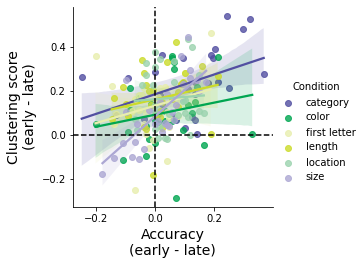

In [34]:
fingerprint_scatterplot_by_category({'accuracy': accuracy_diffs, 'fingerprint': fingerprint_diffs},
    include_conds=non_adaptive_exclude_random, include_lists='Early', y='accuracy', fname='clustering_vs_accuracy_scatterplot_diffs',
    ylabel='Clustering score\n(early - late)', xlabel='Accuracy\n(early - late)');

## Interactions between feature clustering and temporal clustering

### Panels 5, 6, 7, and 8

Same as Panels 1--4, but replace "Accuracy" with average temporal clustering score (on the same sets of lists).

In [35]:
def fingerprint2temporal(f):
    return quail.FriedEgg(data=pd.DataFrame(f.data['temporal']).rename({'temporal': 0}, axis=1),  # this weirdness is needed to put temporal clustering data in the same format as the other eggs
                          analysis=f.analysis, list_length=f.list_length,
                          n_lists=f.n_lists, n_subjects=f.n_subjects, position=f.position)

results['temporal'] = {c: fingerprint2temporal(f) for c, f in results['fingerprint'].items()}



### Panel 5

For each condition, display a single dot for each participant, where the $x$-coordinate shows the early temporal clustering score (averaged across Early lists) and the $y$-coordinate shows the average feature clustering score (for the given condition's highlighted feature).  The resulting scatterplot shows (a) how different list organizations affect clustering and (b) how different list organizations/clustering affects temporal clustering.

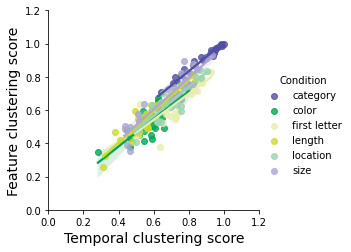

In [36]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, include_lists='Early', y='temporal', fname='clustering_vs_temporal_scatterplot_early',
                                    xlim=[0, 1.2], ylim=[0, 1.2], xlabel='Temporal clustering score', ylabel='Feature clustering score');

### Panel 6

Same as Panel 5, but for Late lists

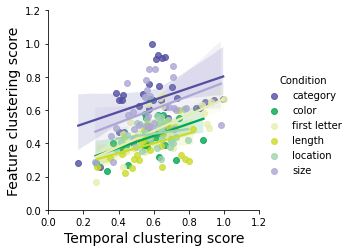

In [37]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, include_lists='Late', y='temporal', fname='clustering_vs_temporal_scatterplot_late',
                                    xlim=[0, 1.2], ylim=[0, 1.2], xlabel='Temporal clustering score', ylabel='Feature clustering score');

### Panel 7

Same as Panels 5 and 6, but the $x$-axis shows temporal clustering on Late lists and the $y$-axis shows feature clustering on Early lists.

The resulting scatterplot shows how/whether feature clustering on early lists relates to temporal clustering on later (random) lists.

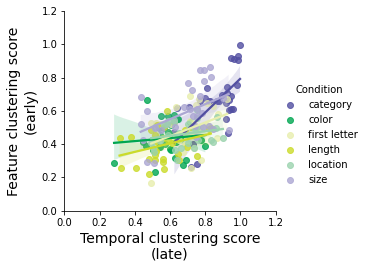

In [38]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, x_lists='Late', y_lists='Early', y='temporal', fname='clustering_vs_temporal_scatterplot_early_vs_late',
   ylabel='Feature clustering score\n(early)', xlabel='Temporal clustering score\n(late)', xlim=[0, 1.2], ylim=[0, 1.2]);

### Panel 8

For each condition, display a single dot for each participant, where the $x$-coordinate shows the early vs. late temporal clustering (averaged across lists) and the $y$-coordinate shows the average feature clustering difference (for the given condition's highlighted feature) between early vs. late lists.

The resulting scatterplot shows how/whether different list organizations carry over to later (random) lists, and how that carryover might interact with temporal clustering differences between early vs. late lists.

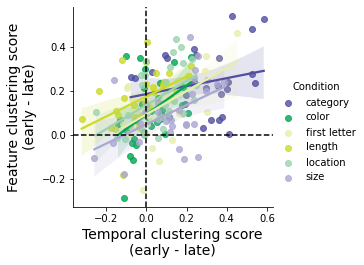

In [39]:
fingerprint_scatterplot_by_category({'temporal': {c: fingerprint2temporal(f) for c, f in fingerprint_diffs.items()}, 'fingerprint': fingerprint_diffs},
    include_conds=non_adaptive_exclude_random, include_lists='Early', y='temporal', fname='clustering_vs_temporal_scatterplot_diffs',
    ylabel='Feature clustering score\n(early - late)', xlabel='Temporal clustering score\n(early - late)');

## Condition-level effects

### Panels 9--16

Same as Panels 1--8, but instead of having 1 dot per person, average (across people) to get one dot per condition.  (See above for descriptions; for analogous panels, subtract 8 from the panel number)

*Panel 9*

For each condition display a single dot (averaged across subjects), where the $x$-coordinate shows the early accuracy (averaged across Early lists) and the $y$-coordinate shows the average clustering score (for the given condition's highlighted feature).  The resulting scatterplot shows (a) how different list organizations affect clustering and (b) how different list organizations/clustering affects recall.

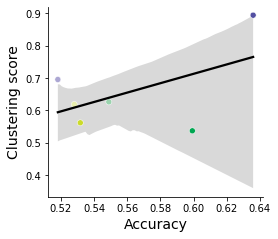

In [40]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, include_lists='Early', y='accuracy', average=True, fname='ave_clustering_vs_accuracy_scatterplot_early');

*Panel 10*

Same as Panel 9, but for late lists.  

This will show whether/how earlier lists' organization affects clustering/performance on later lists.

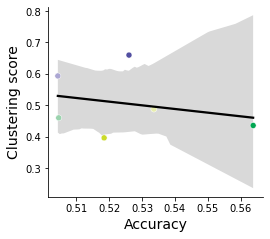

In [41]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, include_lists='Late', y='accuracy', average=True,  fname='ave_clustering_vs_accuracy_scatterplot_late');

*Panel 11*

Same as Panels 9 and 10, but the $x$-axis shows accuracy on Late lists and the $y$-axis shows clustering on Early lists.

The resulting scatterplot shows how/whether clustering on early lists carries over to performance on later (random) lists.

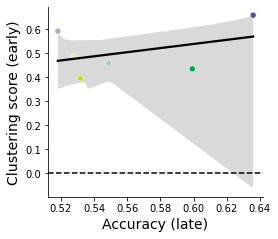

In [42]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, x_lists='Late', y_lists='Early', y='accuracy', average=True,  fname='ave_clustering_vs_accuracy_scatterplot_early_vs_late',
   ylabel='Clustering score (early)', xlabel='Accuracy (late)');

*Panel 12*

For each condition display a single dot (averaged across subjects), where the $x$-coordinate shows the early vs. late accuracy (averaged across lists) and the $y$-coordinate shows the average clustering difference (for the given condition's highlighted feature) between early vs. late lists.

The resulting scatterplot shows how/whether different list organizations carry over to later (random) lists, and how that carryover might interact with recall accuracy differences between early vs. late lists.

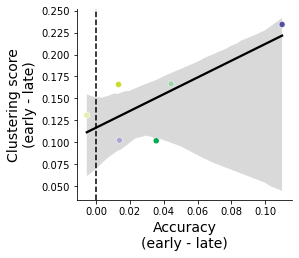

In [43]:
fingerprint_scatterplot_by_category({'accuracy': accuracy_diffs, 'fingerprint': fingerprint_diffs},
    include_conds=non_adaptive_exclude_random, include_lists='Early', y='accuracy', average=True,  fname='ave_clustering_vs_accuracy_scatterplot_diffs',
    ylabel='Clustering score\n(early - late)', xlabel='Accuracy\n(early - late)');

*Panel 13*

For each condition display a single dot (average across subjects), where the $x$-coordinate shows the early temporal clustering score (averaged across Early lists) and the $y$-coordinate shows the average feature clustering score (for the given condition's highlighted feature).  The resulting scatterplot shows (a) how different list organizations affect clustering and (b) how different list organizations/clustering affects temporal clustering.

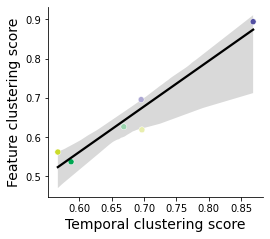

In [44]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, include_lists='Early', y='temporal', average=True,  fname='ave_clustering_vs_temporal_scatterplot_early',
                                    xlabel='Temporal clustering score', ylabel='Feature clustering score');

*Panel 14*

Same as Panel 13, but for Late lists

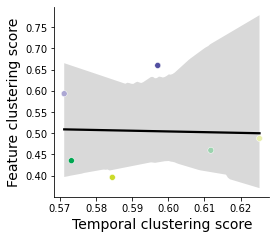

In [45]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, include_lists='Late', y='temporal', average=True,  fname='ave_clustering_vs_temporal_scatterplot_late',
                                    xlabel='Temporal clustering score', ylabel='Feature clustering score');

*Panel 15*

Same as Panels 13 and 14, but the $x$-axis shows temporal clustering on Late lists and the $y$-axis shows feature clustering on Early lists.

The resulting scatterplot shows how/whether feature clustering on early lists relates to temporal clustering on later (random) lists.

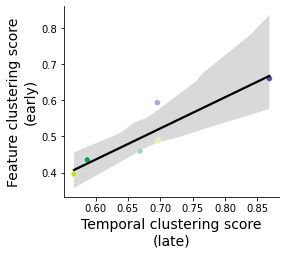

In [46]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, x_lists='Late', y_lists='Early', y='temporal', average=True,  fname='ave_clustering_vs_temporal_scatterplot_early_vs_late',
   ylabel='Feature clustering score\n(early)', xlabel='Temporal clustering score\n(late)');

*Panel 16*

For each condition display a single dot (average across subjects), where the $x$-coordinate shows the early vs. late temporal clustering (averaged across lists) and the $y$-coordinate shows the average feature clustering difference (for the given condition's highlighted feature) between early vs. late lists.

The resulting scatterplot shows how/whether different list organizations carry over to later (random) lists, and how that carryover might interact with temporal clustering differences between early vs. late lists.

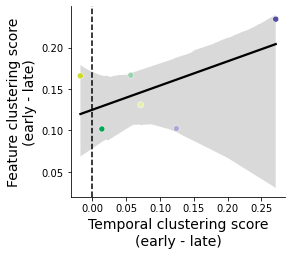

In [47]:
fingerprint_scatterplot_by_category({'temporal': {c: fingerprint2temporal(f) for c, f in fingerprint_diffs.items()}, 'fingerprint': fingerprint_diffs},
    include_conds=non_adaptive_exclude_random, include_lists='Early', y='temporal', average=True,  fname='ave_clustering_vs_temporal_scatterplot_diffs',
    ylabel='Feature clustering score\n(early - late)', xlabel='Temporal clustering score\n(early - late)');

## Similarities in clustering (within each condition)

### Panel 17

For each condition, create a heatmap showing the correlations (across subjects) between clustering scores for different features.  (Alternative: plot this using circos plots.)

In [48]:
def multicaps(x):
    if type(x) is str:
        return x.capitalize()
    elif hasattr(x, '__iter__'):
        return [multicaps(i) for i in x]

def multilower(x):
    if type(x) is str:
        return x.lower()
    elif hasattr(x, '__iter__'):
        return [multilower(i) for i in x]

def clustering_matrices(fingerprints, include_conds='all', include_lists='all'):

    if type(include_conds) is str:
        include_conds = [include_conds]
    
    if type(include_lists) is str:
        include_lists = [include_lists]

    conds = [c for c in fingerprints.keys() if 'all' in include_conds or c in include_conds]

    matrices = {}
    for c in conds:
        matrices[c] = {}

        x = rename_features(fingerprints[c])
        x = x[sort_by_grouping(x.columns, feature_groupings)]
        x.columns = multicaps(x.columns)
        
        lists = np.unique([i[1] for i in x.index]).tolist()

        for ls in lists:
            if 'all' in include_lists or ls in include_lists:
                matrices[c][ls] = x.query(f'List == "{ls}"').corr()

    return matrices

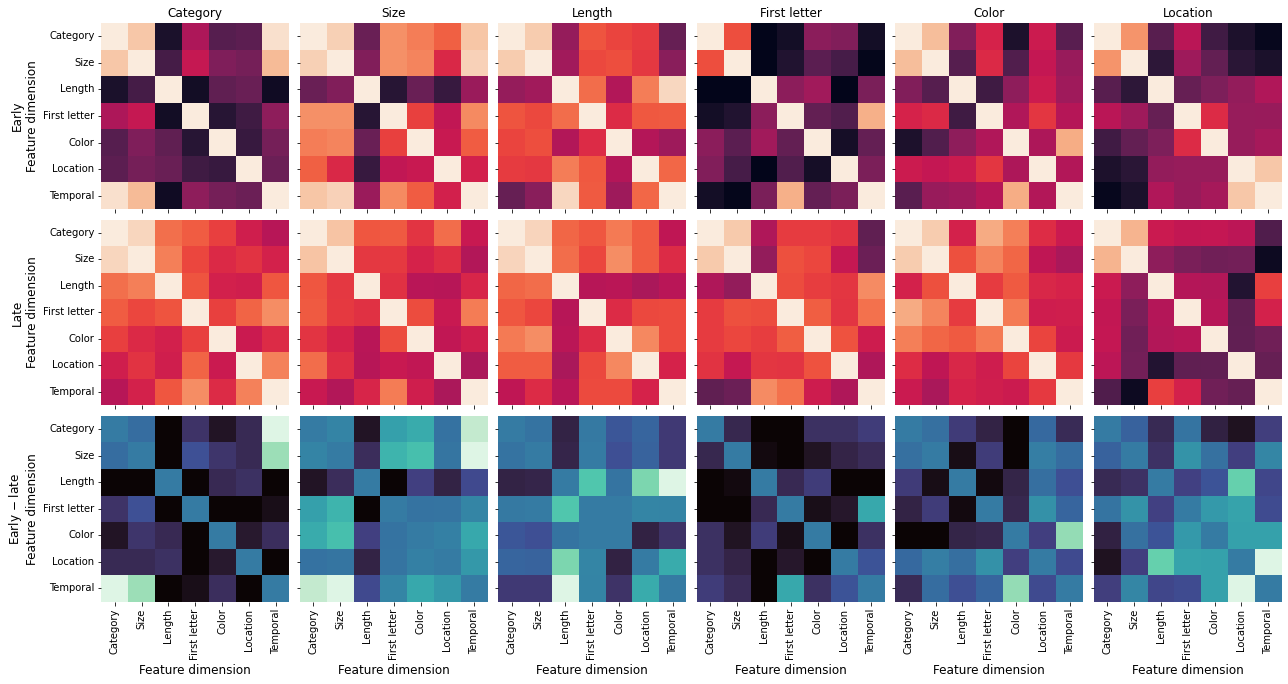

In [59]:
cluster_mats = clustering_matrices(results['fingerprint'], include_conds=non_adaptive_exclude_random, include_lists='all')
plot_heatmaps(cluster_mats, include_conds=non_adaptive_exclude_random, include_lists='all', contrasts={'Early': 'Late'}, fname='clustering_heatmaps_nonadaptive_nonrandom', vmin=-0.1, vmax=1.0, dvmin=-0.5, dvmax=0.5, fontsize=12, width=3, height=3.2, xlabel='Feature dimension', ylabel='Feature dimension');



### Panel 18

Create a matrix where each row is a condition and each column is a feature (including temporal clustering).  Create a 3D hypertools plot where each condition is a dot (colored by condition).

# STOPPED HERE...

In [50]:
def average_by_cond(x, include_conds='all', include_lists='all'):
    x, conds, lists = filter(x, include_conds, include_lists)
    combined = []
    for c in sort_by_grouping(conds, feature_groupings):
        df = pd.DataFrame(rename_features(x[c]).mean(axis=0)).rename({0: c}, axis=1).T

    
    return pd.concat(combined, axis=0)

In [51]:
fingerprints_by_cond = average_by_cond(results['fingerprint'], include_conds=non_adaptive_exclude_random, include_lists='Early')

ValueError: No objects to concatenate

# Figure 6: Fingerprint "carryover" by feature type

This figure is limited to the non-adaptive and non-random feature rich conditions (i.e., conditions with order manipulations on early vs. late lists).

We'll create a scatterplot, where each dot reflects a participant ($x$-coordinate: clustering score for the condition's feature in Early lists; $y$-coordinate: clustering score for the condition's feature in Late lists).  The idea is to show how clustering (for the feature reflected by the current condition) carry over from the Early (organized) lists to the Late (random) lists.

## Panel 1: subject-wise effects



## Panel 2: condition-level effects

Same as panel 1, but average across participants (one dot per condition)

In [ ]:
sns.lmplot(data=carryover_df, x='Clustering score', y='Accuracy', hue='Condition', palette=[colors[c] for c in non_adaptive_exclude_random], height=3.5, aspect=1.1)

ax = plt.gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

plt.plot(xlim, [0, 0], 'k--')
plt.plot([0, 0], ylim, 'k--')
plt.ylim(ylim)
plt.xlim(xlim)

plt.xlabel('Clustering score\n(early $-$ late)', fontsize=14)
plt.ylabel('Recall probability\n(early $-$ late)', fontsize=14)

fig = plt.gcf()
fig.savefig(os.path.join(figdir, 'accuracy_vs_clustering_scatterplot_nonadaptive_nonrandom.pdf'), bbox_inches='tight')


NameError: name 'carryover_df' is not defined

for each type of (main) analysis:

Figure 1:
  - Panel 1: early lists for non-adaptive conditions
  - Panel 2: late lists for non-adaptive conditions
  - Panel 3: adaptive conditions

Figure 2:
  - Panel 1: early vs. late diffs (late - early)
  - Panel 2: stabilize - random, destabilize - random

pfr, lagcrp, spc: line plots

fingerprint, accuracy: bar plots --- *note*: have not made these yet...

---

Figure 3 (aggregate across all conditions/experiments):
  Pnr analyses (for non-adaptive conditions); row: condition, column: position

---

Figure 4: list order effects by condition
  - bar plot of recall accuracy (group: list number; color: condition)

---

Figure 5: Fingerprint "carryover" by feature type (non-adaptive, non-random feature rich only)
  - Scatterplot (color = condition) showing late - early clustering difference (for the given feature type) vs. late - early accuracy
    - idea: does more carryover from early lists increase (or decrease) accuracy on late lists, for any type(s) of features?

---

Figure 6: effects of features:
  - Panel 1: feature rich - reduced for early lists
  - Panel 2: feature rich - reduced for late lists
  - Panel 3: reduced (late) - reduced for late lists
  - Panel 4: feature rich - reduced (early) for late lists

---

Figure 7 (adaptive only)
  Panel 1: Distance from average fingerprint up to that point, by listgroup (x = list number within group; y = distance)
  Panel 2: variance in fingerprints over time, by listgroup
  Panel 3: scatterplot (each listgroup = different color, list number within group = size) where x = distance between current fingerprint vs. average prior to that point and y = accuracy
  

Figure 8: (adaptive only)
  - Panel 1: random; Panel 2: stabilize; Panel 3: destabilize
  - Scatter plots showing (for each feature) average fingerprint (for that feature dimension) on x axis and accuracy (overall) on y axis

Figure 9:
  - Recall trajectories (time = list number, coordinate = fingerprint for that list) for each condition